<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="resources/img/softbutterfly-logo.png" class="pull-left" style="display: block; height: 40px; margin: 0;"><img src="resources/img/jupyter-logo.png" class="pull-right"  style="display: block; height: 20px; margin-top: 10px;">
</div>

<h1 style="text-align:center;">Predicción del Ciclo Solar<div class="divider"></div><small>El algoritmo McNish - Lincoln</small></h1>

<div style="text-align:center">
<b>Martín Josemaría Vuelta Rojas</b><br>
<code>martin.vuelta@softbutterfly.io</code><br/><br/>
<i>Universidad Nacional Mayor de San Marcos</i><br>
Facultad de Ciencias Físicas<br><br>
<i>SoftButterfly</i><br>
Cofundador y Líder del Área de Desarrollo
</div>

## 1 Ajustes gráficos

In [1]:
%matplotlib notebook

In [2]:
# Ajustes generales para los gráficos
from distutils.spawn import find_executable

from matplotlib.font_manager import *
from matplotlib.collections import *
from matplotlib.patches import *
from matplotlib.pylab import *
from matplotlib import colors

import seaborn
import gc

ioff()

rc('lines', linewidth=1)
rc('font', family='serif')

if find_executable('latex'):
    rc('text', usetex=True)

font_title = FontProperties(size=(1.728 * 12))
font_label = FontProperties(size=(1.2 * 12))
font_legend = FontProperties(size=(1.0 * 12))
font_ticks = FontProperties(size=(0.833 * 12))

seaborn.set(context='notebook', style='darkgrid')

## 2 Procesamiento de datos

### 2.1 Registros _crudos_

Los datos de machas solares pueden obtenerse desde la página web de [SILSO](http://www.sidc.be/silso)

In [3]:
import re
from urllib import request

pattern = re.compile(r' +')

try:
    url = "http://www.sidc.be/silso/DATA/SN_d_tot_V2.0.txt"

    req = request.urlopen(url)
    
    raw_data = req.read().decode('utf-8').strip('\n')
except:    
    req = open('./data/data.txt')
    
    raw_data = req.read().strip('\n')
    
raw_data = pattern.sub(' ', raw_data)
raw_data = raw_data.split('\n')[:-1]
raw_data = map(lambda l: l.split(' '), raw_data)
raw_data = list(raw_data)

### 2.2 Registros diarios

In [4]:
from pandas import Timestamp


def flag(t):
    return t == '*'


def pairing(x):
    fns = [Timestamp, float, float, flag]
    return list(zip(fns, ['-'.join(x[0:3])] + x[4:6] + [x[-1]]))


def parse(x):
    return list(map(lambda y: y[0](y[1]), pairing(x)))

In [5]:
daily = list(zip(*map(parse, raw_data)))

In [6]:
from collections import OrderedDict
from pandas import DataFrame
from numpy import nan

headers = ['Date', 'SN value', 'SN error', 'Flag']
daily = DataFrame(OrderedDict(zip(headers, daily))).replace(-1.0, nan)

In [7]:
daily = daily.set_index(["Date"], drop=True)

#### 2.2.1 Gráfico de registros diarios

Los gráficos diarios se realizan en periodos de 50 años empezando desde 1818, el primer año de los registros obtenidos desde [SILSO](http://www.sidc.be/silso)

<IPython.core.display.Javascript object>


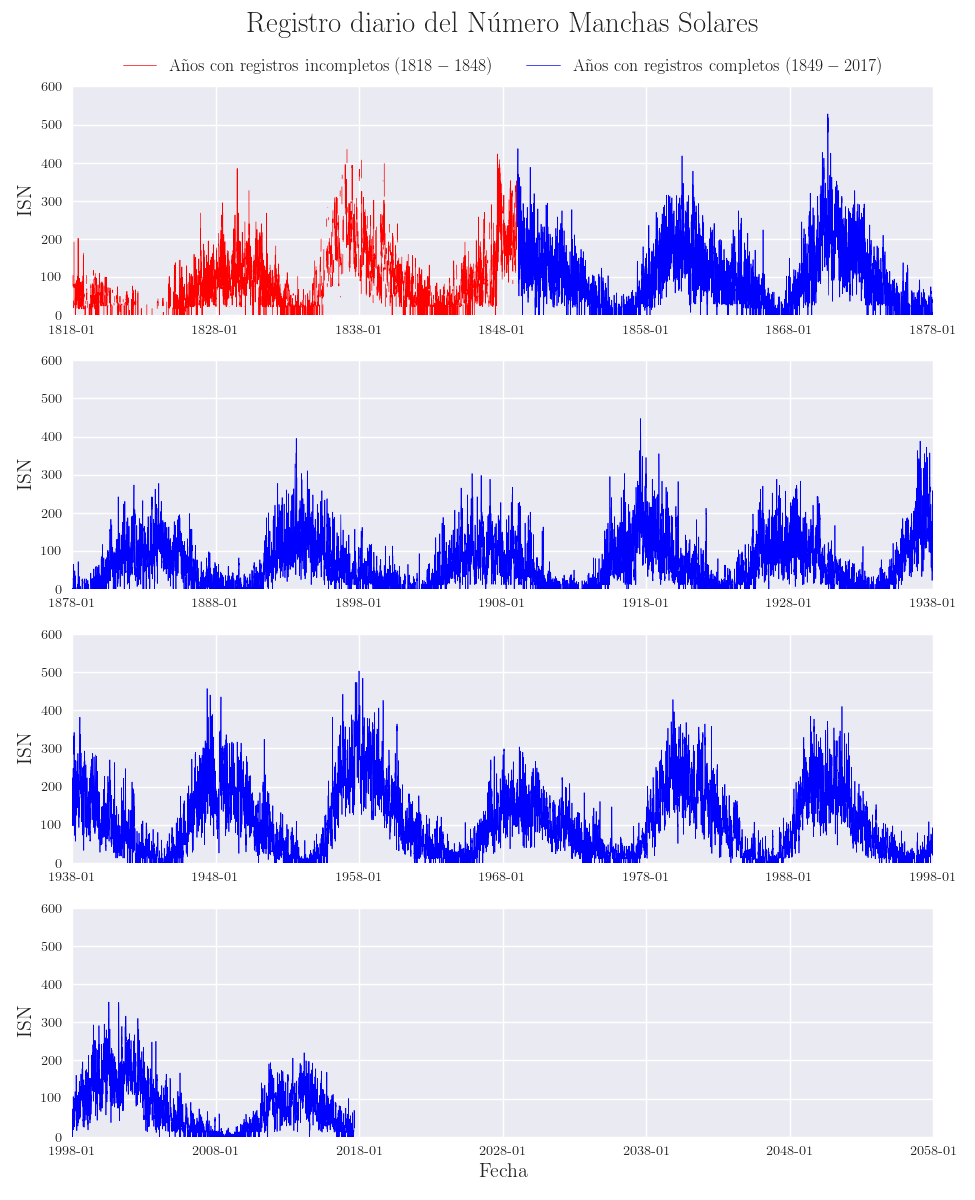

In [8]:
from pandas import Timedelta

yearDelta = 60
periods = (daily.index[-1].year - daily.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(1, figsize=(9.75, periods * 3), frameon=False)

title = r"$\mathrm{Registro\ diario\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(daily['SN value'])[0] / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(daily.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(daily.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = daily[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(plotData['SN value']))[0][-1] + 1
        nanStop = plotData.index[nanStop].year
        nanStop = Timestamp(nanStop, 12, 31)

        graph, = plot(
            plotData[:nanStop]['SN value'],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))
        graph, = plot(
            plotData[nanStop:]['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year + 1,
                    daily.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.20])

        axs.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            borderaxespad=0.0,
            prop=font_legend)

    else:
        plot(
            plotData['SN value'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)
fig.tight_layout()
show()

### 2.3 Promedios mensuales

In [9]:
from numpy import nanmean
from numpy import nanstd
from numpy import isfinite
from numpy import isnan
from numpy import mean
from numpy import sqrt


def agg_mean(x):
    if all(isnan(x)):
        return nan

    return nanmean(x)


def agg_std(x):
    if all(isnan(x)):
        return nan

    return nanstd(x)


def agg_quadsum(x):
    if all(isnan(x)):
        return nan

    return sqrt(sum(x[isfinite(x)]**2))


def agg_all(x):
    return all(x)

In [10]:
monthly = daily.groupby([lambda x: x.year, lambda x: x.month])
monthly = monthly.agg({
    'SN value': [agg_mean, agg_std],
    'SN error': agg_quadsum,
    'Flag': [agg_all]
})

# Flattening labels
monthly.columns = [
    'Monthly SN mean', 'Monthly SN std', 'Monthly SN erros', 'Flag'
]

# Flattening indexes
monthly.index = [Timestamp(y, m, 1) for y, m in monthly.index.values]

#### 2.3.1 Gráfico de promedios mensuales

##### Promedios mensuales

<IPython.core.display.Javascript object>


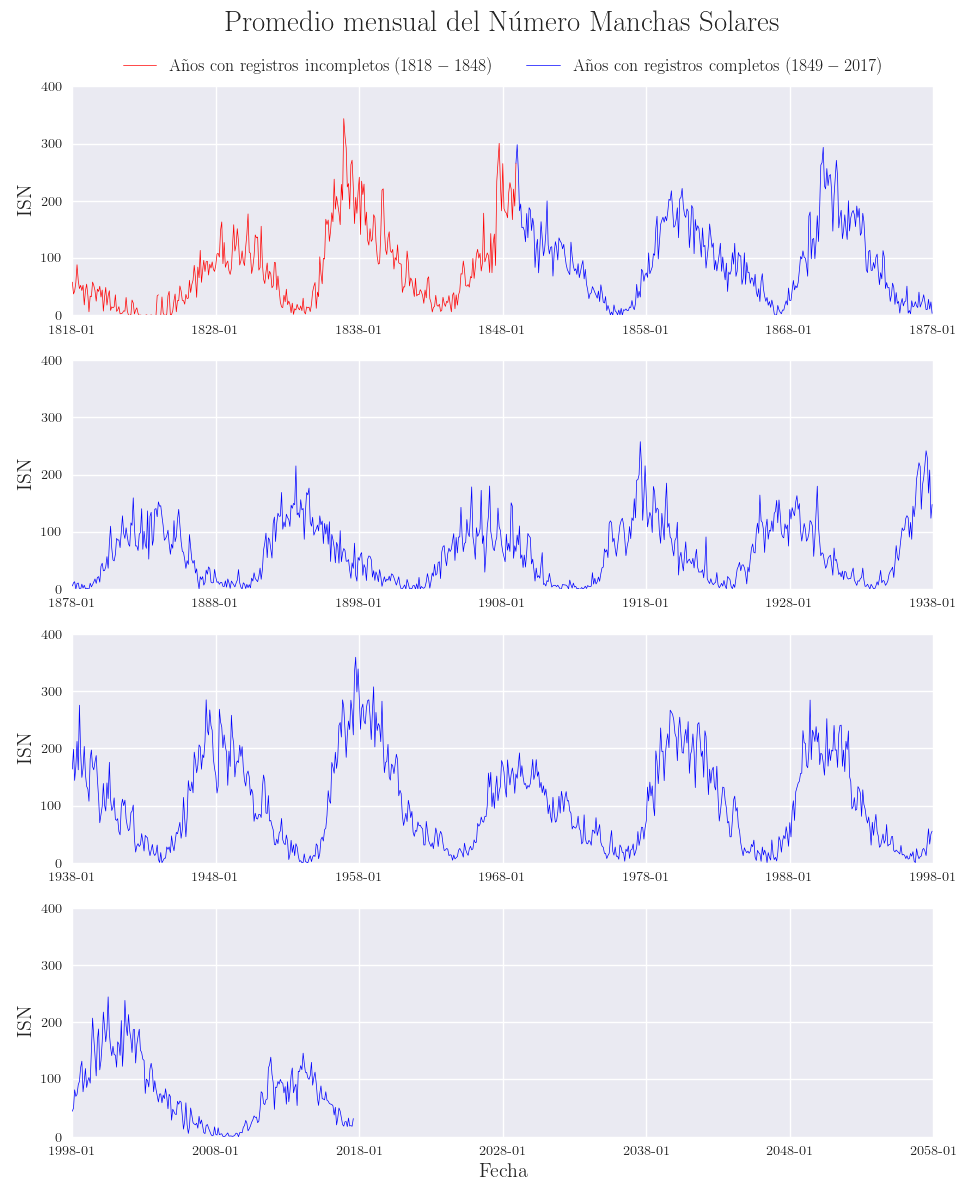

In [11]:
from pandas import Timedelta

yearDelta = 60
periods = (monthly.index[-1].year - monthly.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(2, figsize=(9.75, periods * 3), frameon=False)

title = r"$\mathrm{Promedio\ mensual\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(monthly['Monthly SN mean'])[0] / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(monthly.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(monthly.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = monthly[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(daily['SN value']))[0][-1] + 1
        nanStop = daily.index[nanStop]
        nanStop = plotData[:nanStop].index[-1]
        
        graph, = plot(
            plotData['Monthly SN mean'][:nanStop],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))
        
        graph, = plot(
            plotData['Monthly SN mean'][nanStop:],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year + 1,
                    daily.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.20])
        
        axs.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            borderaxespad=0.0,
            prop=font_legend)
    else:
        plot(
            plotData['Monthly SN mean'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)
fig.tight_layout()
show()

##### Superposición del promedio mensual sobre el registro diario

<IPython.core.display.Javascript object>


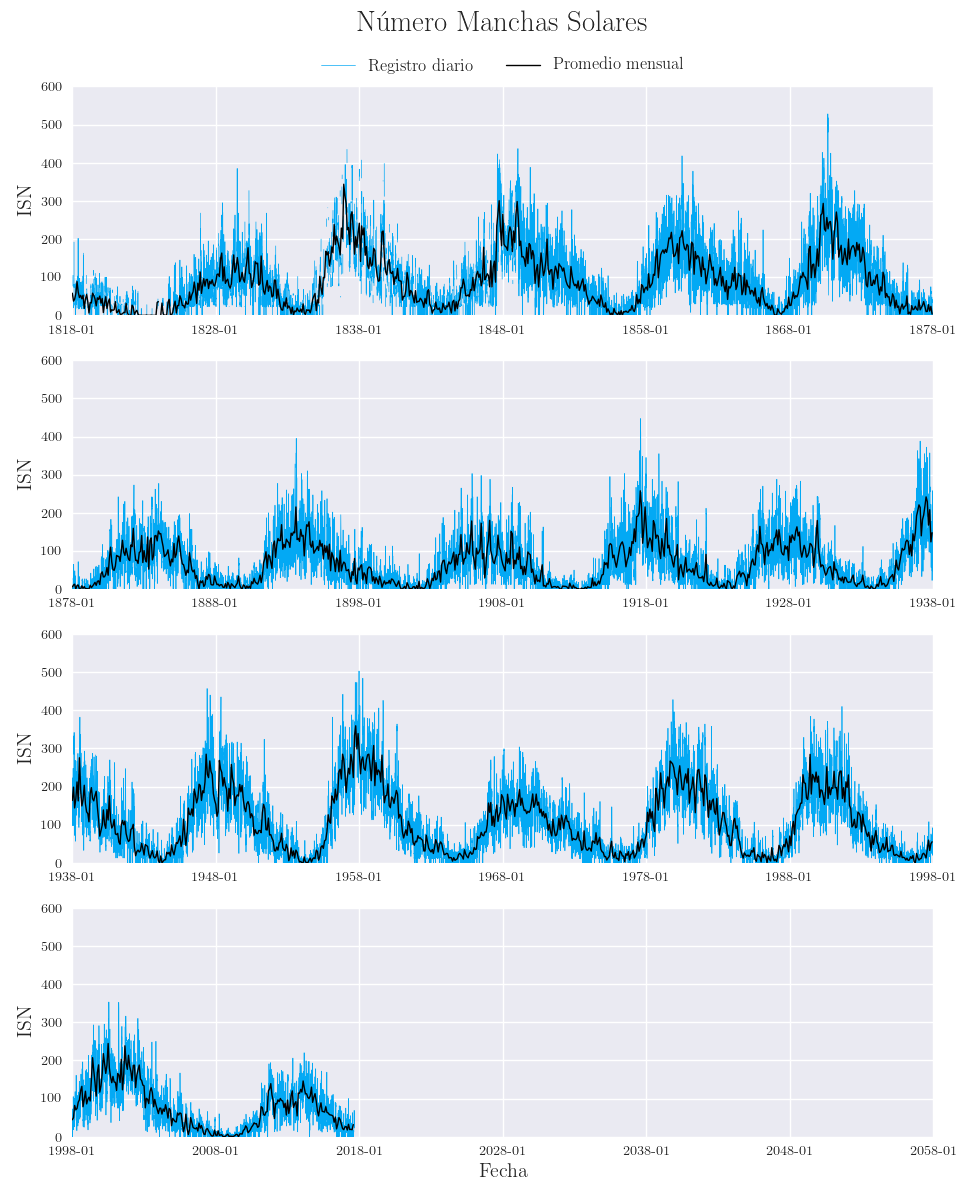

In [12]:
from pandas import Timedelta

yearDelta = 60
periods = (monthly.index[-1].year - monthly.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(3, figsize=(9.75, periods * 3), frameon=False)

title = r"$\mathrm{N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(daily['SN value'])[0] / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(daily.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(daily.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = daily[x_liml:x_limu]

    graph, = plot(
        plotData['SN value'],
        color='#03a9f4',
        linewidth=0.5,
        antialiased=True,
        label=(r"$\mathrm{Registro\ diario}$"))

    plotData = monthly[x_liml:x_limu]

    graph, = plot(
        plotData['Monthly SN mean'],
        color='black',
        linewidth=1.0,
        antialiased=True,
        label=(r"$\mathrm{Promedio\ mensual}$"))

    if i == 0:
        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.20])
        
        axs.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            borderaxespad=0.0,
            prop=font_legend)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil((x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [Timestamp(int(x_liml.year + i * d_xticks), 1, 1)  for i in range(n_xticks + 1)]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)
fig.tight_layout()
show()

### 2.3 Promedios Suavizados cada 13 meses

In [13]:
from pandas import rolling_window


def weighted_average(w):
    def average(x):
        return nansum(w * x)

    return average

w = array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
w = w/sum(w)

smooth = monthly.rolling(window=13, center=True)
smooth = smooth.apply(weighted_average(w))

# Deleting unnused colums
smooth.drop('Monthly SN std', 1, inplace=True)
smooth.drop('Monthly SN erros', 1, inplace=True)
smooth.drop('Flag', 1, inplace=True)

# Renaming columns
smooth.columns = ['Smooth SN mean']

#### 2.3.1 Gráfico de promedios sauvizados

##### Promedio suavizados

<IPython.core.display.Javascript object>


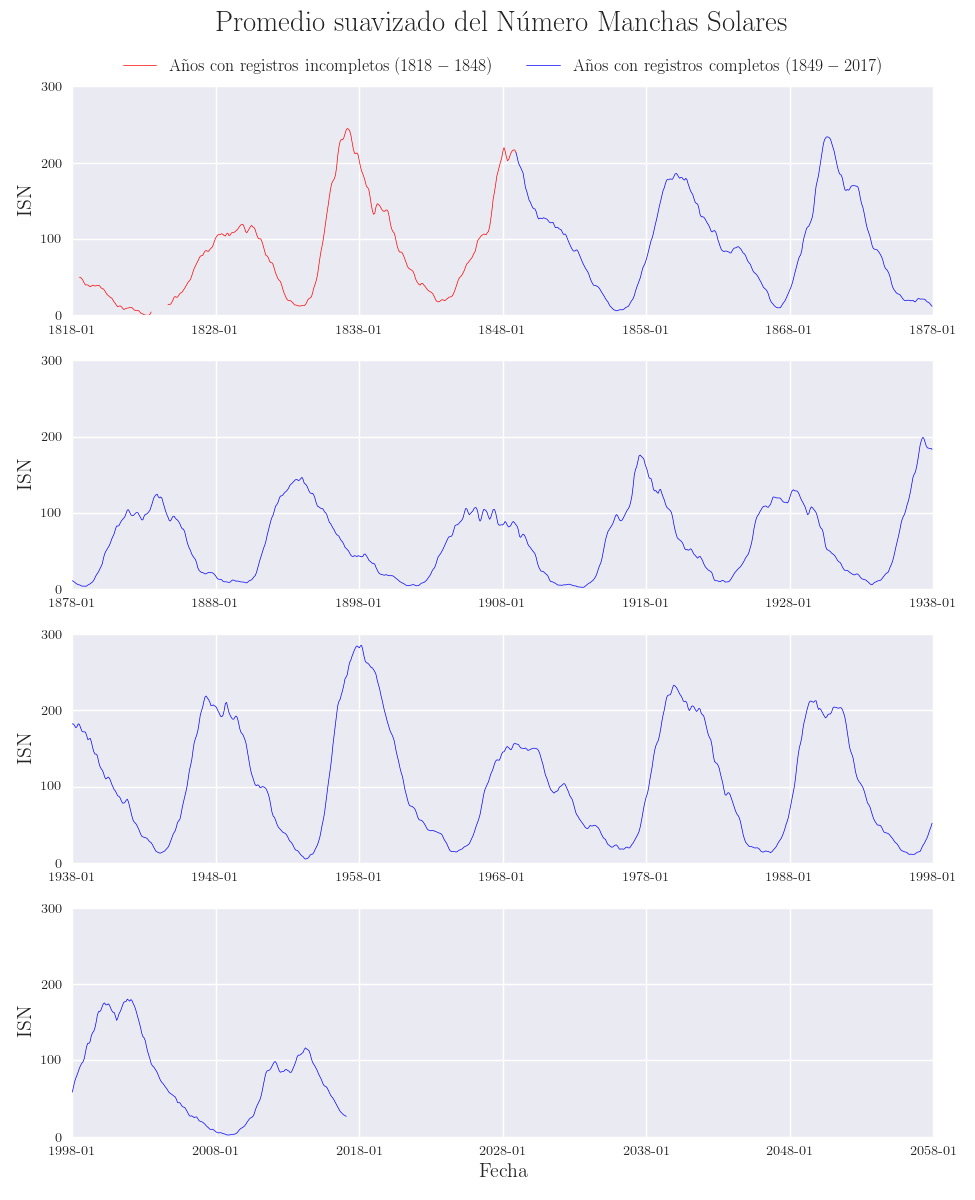

In [14]:
from pandas import Timedelta

yearDelta = 60
periods = (smooth.index[-1].year - smooth.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(4, figsize=(9.75, periods * 3), frameon=False)

title = r"$\mathrm{Promedio\ suavizado\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(smooth['Smooth SN mean'])[0] / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(smooth.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(smooth.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = smooth[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(daily['SN value']))[0][-1] + 1
        nanStop = daily.index[nanStop]
        nanStop = plotData[:nanStop].index[-1]

        graph, = plot(
            plotData['Smooth SN mean'][:nanStop],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))

        graph, = plot(
            plotData['Smooth SN mean'][nanStop:],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year + 1,
                    daily.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.20])

        axs.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            borderaxespad=0.0,
            prop=font_legend)
    else:
        plot(
            plotData['Smooth SN mean'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)
fig.tight_layout()
show()

##### Superposición de promedios sauvizados sobre los mensuales

<IPython.core.display.Javascript object>


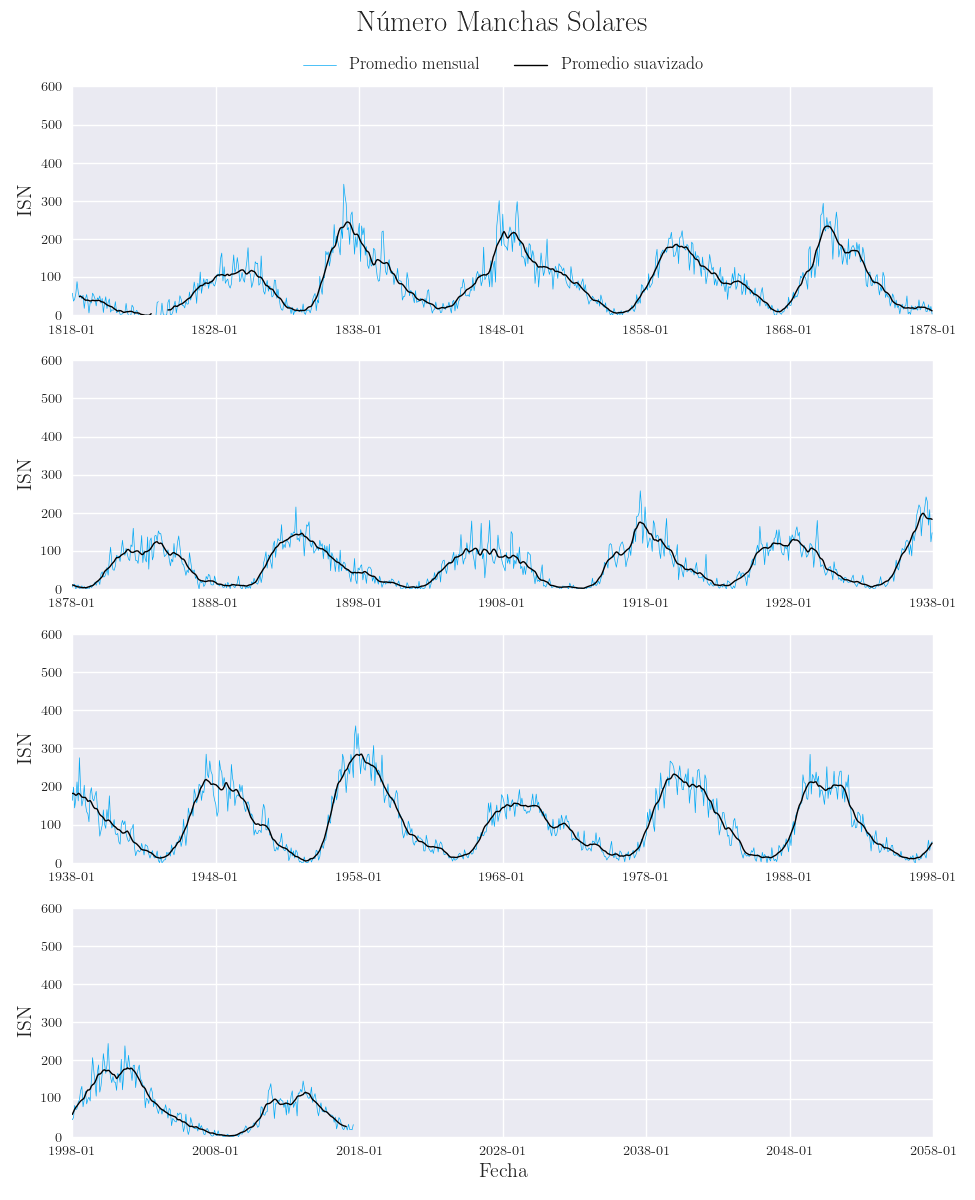

In [15]:
from pandas import Timedelta

yearDelta = 60
periods = (monthly.index[-1].year - monthly.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(5, figsize=(9.75, periods * 3), frameon=False)

title = r"$\mathrm{N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(daily['SN value'])[0] / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(daily.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(daily.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = monthly[x_liml:x_limu]

    graph, = plot(
        plotData['Monthly SN mean'],
        color='#03a9f4',
        linewidth=0.5,
        antialiased=True,
        label=(r"$\mathrm{Promedio\ mensual}$"))

    plotData = smooth[x_liml:x_limu]

    graph, = plot(
        plotData['Smooth SN mean'],
        color='black',
        linewidth=1.0,
        antialiased=True,
        label=(r"$\mathrm{Promedio\ suavizado}$"))

    if i == 0:
        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.20])

        axs.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=3,
            borderaxespad=0.0,
            prop=font_legend)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)
fig.tight_layout()
show()

## 3 Separación de ciclos

### 3.1 Detección de picos

#### 3.1.1 Algoritmo de detección

In [16]:
def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    
    return x_axis, y_axis

In [17]:
def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    """
    Converted from/based on a MATLAB script at: 
    http://billauer.co.il/peakdet.html
    
    function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower
    or larger values for maxima and minima respectively
    
    keyword arguments:
    y_axis -- A list containing the signal over which to find peaks
    
    x_axis -- A x-axis whose values correspond to the y_axis list and is used
        in the return to specify the position of the peaks. If omitted an
        index of the y_axis is used.
        (default: None)
    
    lookahead -- distance to look ahead from a peak candidate to determine if
        it is the actual peak
        (default: 200) 
        '(samples / period) / f' where '4 >= f >= 1.25' might be a good value
    
    delta -- this specifies a minimum difference between a peak and
        the following points, before a peak may be considered a peak. Useful
        to hinder the function from picking up false peaks towards to end of
        the signal. To work well delta should be set to delta >= RMSnoise * 5.
        (default: 0)
            When omitted delta function causes a 20% decrease in speed.
            When used Correctly it can double the speed of the function
    
    
    return: two lists [max_peaks, min_peaks] containing the positive and
        negative peaks respectively. Each cell of the lists contains a tuple
        of: (position, peak_value) 
        to get the average peak value do: np.mean(max_peaks, 0)[1] on the
        results to unpack one of the lists into x, y coordinates do: 
        x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        #no peaks were found, should the function return empty lists?
        pass
        
    return [max_peaks, min_peaks]

#### 3.1.1 Gráfico interactivo para la eliminación de falsos positivos

<IPython.core.display.Javascript object>


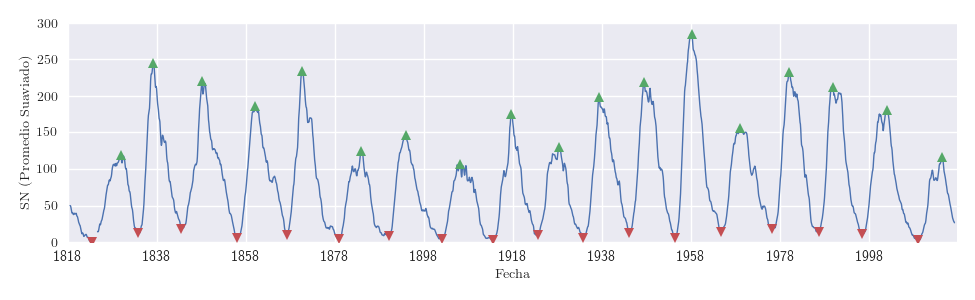

In [18]:
from IPython.display import display
from ipywidgets import *

w_lookahead = IntSlider(min=1, max=100, step=1, value=20)
wc_lookahead = VBox([Label(value='Lookahead'), w_lookahead])

w_delta = IntSlider(min=1, max=100, step=1, value=1)
wc_delta = VBox([Label(value='Delta'), w_delta])

wc_controllers = HBox([wc_lookahead, wc_delta])

w_maxima_label = Label(value="Máximos")
w_maxima_label.layout.width = '100%'

w_maxima_selector = SelectMultiple(options=[])

w_maxima_clean = Button(description='Limpiar seleción de máximos')
w_maxima_clean.layout.margin = '5px 2px 0'
w_maxima_clean.layout.width = '300px'

wc_maxima = VBox([w_maxima_label, w_maxima_selector, w_maxima_clean])


w_minima_label = Label(value="Máximos")
w_minima_label.layout.width = '100%'

w_minima_selector = SelectMultiple(options=[])

w_minima_clean = Button(description='Limpiar seleción de mínimos')
w_minima_clean.layout.margin = '5px 2px 0'
w_minima_clean.layout.width = '300px'

wc_minima = VBox([w_minima_label, w_minima_selector, w_minima_clean])

wc_peaks = HBox([wc_maxima, wc_minima])

w_output = Output()

wc_container = VBox([wc_controllers, wc_peaks, w_output])


def update_peaks(*args):
    maxima, minima = peakdetect(
        smooth['Smooth SN mean'].values,
        smooth.index.values,
        lookahead=w_lookahead.value,
        delta=w_delta.value)

    wc_maxima.children[0].value = "Máximos ({0:})".format(len(maxima))
    wc_minima.children[0].value = "Mínimos ({0:})".format(len(minima))

    minima = [
        '{0:0>2d}: '.format(n + 1) + Timestamp(d).strftime("%Y-%m") +
        ' ({0:.3f})'.format(v) for n, (d, v) in enumerate(minima)
    ]
    maxima = [
        '{0:0>2d}: '.format(n + 1) + Timestamp(d).strftime("%Y-%m") +
        ' ({0:.3f})'.format(v) for n, (d, v) in enumerate(maxima)
    ]

    w_minima_selector.options = minima
    w_maxima_selector.options = maxima


def clean_peaks(*args):
    if args[0] == w_maxima_clean:
        w_maxima_selector.value = []

    elif args[0] == w_minima_clean:
        w_minima_selector.value = []

    else:
        pass


def plotter(*args):
    maxima = list(
        zip(*map(lambda x: (x, smooth['Smooth SN mean'][x]),
                 map(lambda x: Timestamp(*x),
                     map(lambda x: list(map(int, x)) + [1],
                         map(lambda x: x[1].split('-'),
                             map(lambda x: x.split(' '),
                                 filter(lambda x: x not in w_maxima_selector.value,
                                        w_maxima_selector.options))))))))

    minima = list(
        zip(*map(lambda x: (x, smooth['Smooth SN mean'][x]),
                 map(lambda x: Timestamp(*x),
                     map(lambda x: list(map(int, x)) + [1],
                         map(lambda x: x[1].split('-'),
                             map(lambda x: x.split(' '),
                                 filter(lambda x: x not in w_minima_selector.value,
                                        w_minima_selector.options))))))))

    fig = figure(6, figsize=(9.75, 3), frameon=False)
    fig.clf()
    axs = fig.add_subplot('111')

    gsmooth, = axs.plot(
        smooth,
        linewidth=1
    )

    gmaxima, = axs.plot(
        maxima[0],
        maxima[1],
        linewidth=0.0,
        marker='^', )

    gminima, = axs.plot(
        minima[0],
        minima[1],
        linewidth=0.0,
        marker='v', )

    axs.set_xlim([daily.index[0], daily.index[-1]])
    axs.set_xlabel(r'$\mathrm{Fecha}$', fontproperties=font_ticks)
    axs.set_ylim([0, ceil(nanmax(smooth['Smooth SN mean'].values)/100.0)*100])
    axs.set_ylabel(r'$\mathrm{SN\ (Promedio\ Suaviado)}$', fontproperties=font_ticks)
    fig.tight_layout()
    show()


w_lookahead.observe(update_peaks, 'value')
w_lookahead.observe(plotter, 'value')

w_delta.observe(update_peaks, 'value')
w_delta.observe(plotter, 'value')

w_maxima_selector.observe(plotter, 'value')
w_maxima_clean.on_click(clean_peaks)

w_minima_selector.observe(plotter, 'value')
w_minima_clean.on_click(clean_peaks)

wc_container.on_displayed(update_peaks)
wc_container.on_displayed(plotter)

display(wc_container)

### 3.2 Seleción de ciclos

#### 3.3.1 División de ciclos entre mínimos

In [61]:
minima = list(
        zip(*map(lambda x: (x, smooth['Smooth SN mean'][x]),
                 map(lambda x: Timestamp(*x),
                     map(lambda x: list(map(int, x)) + [1],
                         map(lambda x: x[1].split('-'),
                             map(lambda x: x.split(' '),
                                 filter(lambda x: x not in w_minima_selector.value,
                                        w_minima_selector.options))))))))

stops = [smooth.index[0]] + list(minima[0])
lengths = diff(array(list(map(smooth.index.get_loc, stops))))
maxlength = max(lengths)

headers = []
lcycles = []
dfcycles = ones((len(stops), maxlength))*nan

for i in range(len(stops)):
    h = "Cycle {0:>2d}".format(i+6)
    
    if i == len(stops) - 1:
        c = smooth[stops[i]:]
    else:
        c = smooth[stops[i]:stops[i+1]-Timedelta(1, 'd')]
    
    c.columns = [h]
    v = c[h].values
    l = len(v)
    
    lcycles.append(c)
    headers.append(h)
    dfcycles[i][:l] = v

dfcycles = DataFrame(OrderedDict(zip(headers, dfcycles)))

#### 3.3.2 Gráfico interactivo para la seleción de ciclos

<IPython.core.display.Javascript object>


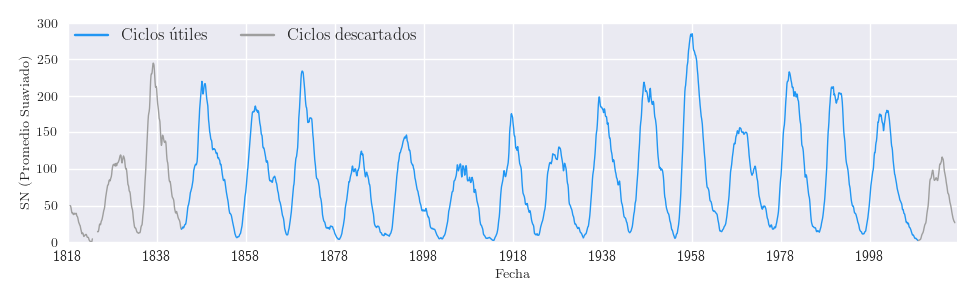

In [84]:
deleted_cycles = []

w_cycles_label = Label(value="Ciclos solares")
w_cycles_label.layout.width = '100%'

w_cycles_selector = SelectMultiple(
    options=headers,
    value=headers[0:3]
    
)

w_cycles_clean = Button(description='Limpiar seleción de ciclos')
w_cycles_clean.layout.margin = '5px 2px 0'
w_cycles_clean.layout.width = '300px'

w_cycles_delete = Button(description='Eliminar ciclos selecionados', button_style='warning')
w_cycles_delete.layout.margin = '5px 2px 0'
w_cycles_delete.layout.width = '300px'

wc_cycles = VBox([w_cycles_label, w_cycles_selector, w_cycles_clean,  w_cycles_delete])

def select_cycles(*args):
    w_cycles_delete.button_style = 'warning'
    deleted_cycles = list(w_cycles_selector.value)
    
    if headers[-1] not in deleted_cycles:
        w_cycles_selector.value = deleted_cycles + [headers[-1]]
    
def plot_cycles(*args):
    deleted_cycles = w_cycles_selector.value
    
    fig = figure(7, figsize=(9.75, 3), frameon=False)
    fig.clf()
    axs = fig.add_subplot('111')

    for cycle in lcycles:
        if cycle.columns[0] in deleted_cycles or cycle.columns[0] == headers[-1]:
            color = '#9e9e9e' 
        else:
            color='#2196f3'
            
        gsmooth, = axs.plot(
            cycle,
            color=color,
            linewidth=1
        )
        
    util_cyles = Line2D([], [], color='#2196f3', label=r'$\mathrm{Ciclos\ \acute{u}tiles}$')
    no_util_cyles = Line2D([], [], color='#9e9e9e', label=r'$\mathrm{Ciclos\ descartados}$')

    axs.legend(
        handles=[util_cyles, no_util_cyles],
        loc='upper left',
        ncol=2,
        borderaxespad=0.0,
        prop=font_legend)
            
    axs.set_xlim([smooth.index[0], smooth.index[-1]])
    axs.set_xlabel(r'$\mathrm{Fecha}$', fontproperties=font_ticks)
    axs.set_ylim([0, ceil(nanmax(smooth['Smooth SN mean'].values)/100.0)*100])
    axs.set_ylabel(r'$\mathrm{SN\ (Promedio\ Suaviado)}$', fontproperties=font_ticks)
    fig.tight_layout()
    show()


def reset_cycles(*args):
    global dfcycles
    
    if list(dfcycles.columns.values) != headers:
        dfcycles = ones((len(stops), maxlength))*nan

        for i in range(len(stops)):
            h = "Cycle {0:>2d}".format(i+6)

            if i == len(stops) - 1:
                c = smooth[stops[i]:]
            else:
                c = smooth[stops[i]:stops[i+1]-Timedelta(1, 'd')]
            
            c.columns = [h]
            v = c[h].values
            l = len(v)

            dfcycles[i][:l] = v

        dfcycles = DataFrame(OrderedDict(zip(headers, dfcycles)))

def clean_cycles(*args):
    w_cycles_selector.value = [headers[-1]]

def delete_cycles(*args):
    global dfcycles
    
    deleted_cycles = w_cycles_selector.value
    
    for header in deleted_cycles:
        if header in dfcycles.columns:
            dfcycles.drop(header, axis=1, inplace=True)
    
    w_cycles_delete.button_style = 'success'
    
w_cycles_selector.observe(select_cycles, 'value')
w_cycles_selector.observe(plot_cycles, 'value')

w_cycles_clean.on_click(clean_cycles)
w_cycles_delete.on_click(delete_cycles)


wc_cycles.on_displayed(reset_cycles)
wc_cycles.on_displayed(select_cycles)
wc_cycles.on_displayed(plot_cycles)

display(wc_cycles)

#### 3.3.2 Construcción del ciclo pormedio